In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from scipy.io import arff

In [7]:
train_raw,meta = arff.loadarff('../data/Epilepsy_TRAIN.arff')

In [8]:
train_pd = pd.DataFrame(train_raw)

**adding a column that is 1 if seizure and 0 if not seizure**

In [9]:
train_pd['label_binary'] = np.where(train_pd['activity']==b'EPILEPSY',1,0)

In [10]:
train_pd

,relationalAtt,activity,label_binary
0,"[[0.35, 0.4, 0.44, 0.47, 0.48, 0.47, 0.44, 0.4...",b'EPILEPSY',1
1,"[[-0.91, -0.92, -0.95, -0.95, -0.95, -0.94, -0...",b'EPILEPSY',1
2,"[[0.32, 0.71, 0.7, 0.75, 0.88, 0.58, 1.34, 0.6...",b'EPILEPSY',1
3,"[[-0.68, -0.36, -0.13, -0.38, -0.49, -0.48, -0...",b'EPILEPSY',1
4,"[[0.34, 0.53, 0.58, 0.61, 0.64, 0.63, 0.44, 0....",b'EPILEPSY',1
...,...,...,...
132,"[[0.45, -0.28, 0.28, 1.33, 1.01, 0.06, -0.11, ...",b'SAWING',0
133,"[[0.24, -0.79, -0.65, 0.07, 1.5, 1.55, 0.94, 0...",b'SAWING',0
134,"[[1.16, -0.02, -1.04, -0.81, 0.36, 1.69, 0.93,...",b'SAWING',0
135,"[[-0.74, -0.14, 0.12, -0.08, -0.78, -1.42, -1....",b'SAWING',0


**brake it u into train and val**


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train_pd['relationalAtt'], train_pd['label_binary'], test_size=0.35, random_state=666,shuffle=True)

In [13]:
X_train

95     [[0.73, 0.54, -0.53, -1.79, -1.75, -1.02, -0.6...
61     [[-0.96, -0.91, -0.79, -0.75, -0.8, -1.0, -1.3...
107    [[1.8, 1.72, 1.09, 0.3, -0.68, -0.58, 0.13, 1....
127    [[0.46, 0.68, 0.7, 0.29, 0.23, 0.76, 0.98, 0.3...
84     [[-1.13, -0.9, -0.87, -0.62, -0.81, -1.16, -1....
                             ...                        
51     [[0.07, 0.02, 0.26, 0.65, 0.88, 1.0, 0.88, 0.8...
91     [[-3.13, -2.22, -1.62, -1.28, -1.73, -2.91, -1...
70     [[0.32, 0.22, 0.19, 0.3, 0.44, 0.55, 0.49, 0.3...
62     [[-0.71, -1.21, -1.46, -1.36, -1.45, -1.27, -0...
130    [[0.5, 0.53, 0.06, -0.16, 0.1, 0.97, 1.5, 1.09...
Name: relationalAtt, Length: 89, dtype: object

In [14]:
#percent positive samples in train set
len(y_train[y_train.values==1])/len(y_train.values)

0.21348314606741572

In [15]:
#percent positive examples in test set
len(y_val[y_val.values==1])/len(y_val.values)

0.3125

**there is clas imbalance but i will start simple with out over sampling and see how it goes**

In [16]:
len(X_train.index) #num of samples in x train

89

In [17]:
len(X_train.iloc[0]) #num of channels

3

In [18]:
len(X_train.iloc[0][0]) #length of series

206

In [19]:
test = pd.DataFrame(X_train)

In [20]:
test

,relationalAtt
95,"[[0.73, 0.54, -0.53, -1.79, -1.75, -1.02, -0.6..."
61,"[[-0.96, -0.91, -0.79, -0.75, -0.8, -1.0, -1.3..."
107,"[[1.8, 1.72, 1.09, 0.3, -0.68, -0.58, 0.13, 1...."
127,"[[0.46, 0.68, 0.7, 0.29, 0.23, 0.76, 0.98, 0.3..."
84,"[[-1.13, -0.9, -0.87, -0.62, -0.81, -1.16, -1...."
...,...
51,"[[0.07, 0.02, 0.26, 0.65, 0.88, 1.0, 0.88, 0.8..."
91,"[[-3.13, -2.22, -1.62, -1.28, -1.73, -2.91, -1..."
70,"[[0.32, 0.22, 0.19, 0.3, 0.44, 0.55, 0.49, 0.3..."
62,"[[-0.71, -1.21, -1.46, -1.36, -1.45, -1.27, -0..."


**next goal is to reshape my train df into 4 dimentional array (# of samples, height of "image", width, channels) => (89,1,206,3)**                                

In [22]:
def reshape_for_nn(X):
    X_4d = np.zeros(shape=(len(X.index),1 ,len(X.iloc[0][0]),len(X_train.iloc[0])))
    #create the chanel arrays seperaty
    pd_df = pd.DataFrame(X)
    x_channel = np.reshape(np.array(list(pd_df.iloc[0,:][0][0])),(1,-1))#[0]
    y_channel = np.reshape(np.array(list(pd_df.iloc[0,:][0][1])),(1,-1))
    #z_channel = 
    
    for i in range(len(X.index)):
        pass
        print(X_4d[i].shape)
    return x_channel


In [98]:
test = reshape_for_nn(X_train)

In [99]:
test.shape

(1, 206)

**I just realized I think i want to try this with polar coords**

In [23]:
train_pd.head()

,relationalAtt,activity,label_binary
0,"[[0.35, 0.4, 0.44, 0.47, 0.48, 0.47, 0.44, 0.4...",b'EPILEPSY',1
1,"[[-0.91, -0.92, -0.95, -0.95, -0.95, -0.94, -0...",b'EPILEPSY',1
2,"[[0.32, 0.71, 0.7, 0.75, 0.88, 0.58, 1.34, 0.6...",b'EPILEPSY',1
3,"[[-0.68, -0.36, -0.13, -0.38, -0.49, -0.48, -0...",b'EPILEPSY',1
4,"[[0.34, 0.53, 0.58, 0.61, 0.64, 0.63, 0.44, 0....",b'EPILEPSY',1


In [27]:
##convert to the rho component of polar coordinance
def to_rho(x,y,z):
    rho = np.sqrt(x**2 + y**2 + z**2)
    return rho

def to_theta(x,y):
    return np.arctan(y/x)

def to_phi(x,y,z):
    return np.arccos(z/to_rho(x,y,z))

## convert x,y,and z array to rho array
def cart_to_polar(x_array,y_array,z_array):
    '''input three array representing x y and z
        out put three arrays representing rho,theta, phi'''
    rho = np.array([])
    theta = np.array([])
    phi = np.array([])
    for i in range(len(x_array)):
        rho = np.append(rho,to_rho(x_array[i],y_array[i],z_array[i]))
        theta = np.append(theta, to_theta(x_array[i],y_array[i]))
        phi = np.append(phi,to_phi(x_array[i],y_array[i],z_array[i]))
    return rho,theta,phi




def df_to_rho_phi(df):
    rho_df = np.empty((0,206))
    #theta_df = np.empty((0,206))
    phi_df = np.empty((0,206))
    
    ### for each row
    for row in df.iterrows():
        
        ### create x y z from each row
        x_array= list(row[1][0][0])
        x_array = np.array(x_array)
        x_array = np.reshape(x_array,(1,-1))#[0]
        
        y_array = list(row[1][0][1])
        y_array = np.array(y_array)
        y_array = np.reshape(y_array,(1,-1))#[0]
        
        z_array = list(row[1][0][2])
        z_array = np.array(z_array)
        z_array = np.reshape(z_array,(1,-1))#[0]
        
        #make a new sample that is just rho
        rho,theta,phi = cart_to_polar(x_array,y_array,z_array)
        rho = np.reshape(rho,(1,-1))
        phi = np.reshape(phi,(1,-1))
       #creat new df convertes to just the rho element of polar coordinanace
    
        rho_df = np.append(rho_df, rho,axis=0)
        phi_df = np.append(phi_df,phi,axis=0)
        

    return np.dstack((rho_df,phi_df))


In [31]:
rho_phi = df_to_rho_phi(train_pd)

/home/rachel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [32]:
rho_phi.shape

(137, 206, 2)

In [35]:
#check for nans since i got that pink error
sum_ = np.sum(rho_phi)
has_nan = np.isnan(sum_)

In [36]:
has_nan

False

In [37]:
type(rho_phi)

numpy.ndarray

In [38]:
rho_phi_3d = rho_phi.reshape((137,1,206,2))

In [42]:
rho_phi_3d_2 = rho_phi.reshape(137,206,2)

In [43]:
rho_phi_3d_2[0].shape

(206, 2)

In [45]:
rho_phi_3d_2.shape

(137, 206, 2)

Text(0.5, 0, 'Time')

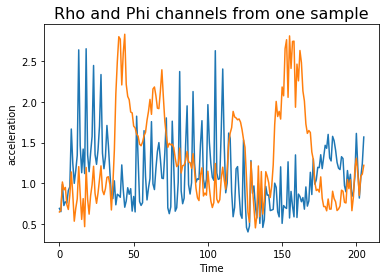

In [47]:
plt.plot(rho_phi_3d_2[0])
plt.title('Rho and Phi channels from one sample',size=16)
plt.ylabel('acceleration')
plt.xlabel('Time')

In [48]:
y = train_pd['label_binary'].values

In [49]:
X_train_rhophi, X_vali_rhophi, y_train_rhophi, y_vali_rhophi = train_test_split(rho_phi_3d_2, y, test_size = 0.25, random_state = 666)

**data is in the right shape. now lets invoke tensor board before we build the model and train**

In [474]:
from keras.callbacks import TensorBoard
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling1D, MaxPool1D, Dropout,Conv1D,MaxPooling2D

In [503]:
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(206,2)))
model1.add(Dropout(0.5))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(Dropout(0.5))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(100, activation='relu'))
model1.add(Dense(50, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [498]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 204, 64)           448       
_________________________________________________________________
dropout_12 (Dropout)         (None, 204, 64)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 102, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 64)           12352     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)             

In [485]:
metrics1 = ['accuracy','TruePositives', 'TrueNegatives','FalsePositives','FalseNegatives','Precision','Recall']

In [504]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics1)

In [505]:
batch_size=32

In [506]:
tensorboard = TensorBoard(log_dir='./logs7', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True)
model1_hist = model1.fit(X_train_rhophi, y_train_rhophi, batch_size=batch_size, epochs=300, 
          validation_data = (X_vali_rhophi,y_vali_rhophi), callbacks = [tensorboard])

Epoch 1/300
4/4 [==============================] - 1s 182ms/step - loss: 0.7776 - accuracy: 0.5882 - true_positives: 3.0000 - true_negatives: 57.0000 - false_positives: 22.0000 - false_negatives: 20.0000 - precision: 0.1200 - recall: 0.1304 - val_loss: 0.6398 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 14ms/step - loss: 0.5576 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6300 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 0s 31ms

4/4 [==============================] - 0s 30ms/step - loss: 0.2823 - accuracy: 0.9020 - true_positives: 13.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 10.0000 - precision: 1.0000 - recall: 0.5652 - val_loss: 0.4281 - val_accuracy: 0.8571 - val_true_positives: 8.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 3.0000 - val_precision: 0.8000 - val_recall: 0.7273
Epoch 18/300
4/4 [==============================] - 0s 16ms/step - loss: 0.2718 - accuracy: 0.9412 - true_positives: 20.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 3.0000 - precision: 0.8696 - recall: 0.8696 - val_loss: 0.3555 - val_accuracy: 0.8857 - val_true_positives: 7.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 4.0000 - val_precision: 1.0000 - val_recall: 0.6364
Epoch 19/300
4/4 [==============================] - 0s 28ms/step - loss: 0.2195 - accuracy: 0.9216 - true_positi

4/4 [==============================] - 0s 30ms/step - loss: 0.0892 - accuracy: 0.9706 - true_positives: 20.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 3.0000 - precision: 1.0000 - recall: 0.8696 - val_loss: 0.3156 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 36/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0705 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 0.2560 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 37/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0724 - accuracy: 0.9804 - true_positiv

4/4 [==============================] - 0s 28ms/step - loss: 0.0258 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 0.2324 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 54/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0168 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 0.2303 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 55/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0148 - accuracy: 1.0000 - true_positiv

4/4 [==============================] - 0s 28ms/step - loss: 0.0489 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 0.2180 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 72/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0155 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3132 - val_accuracy: 0.9429 - val_true_positives: 11.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 0.0000e+00 - val_precision: 0.8462 - val_recall: 1.0000
Epoch 73/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0358 - accuracy: 1.0000 - tru

4/4 [==============================] - 0s 28ms/step - loss: 0.0013 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2118 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 90/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0043 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2044 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 91/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0096 - accuracy: 0.9902 - true

4/4 [==============================] - 0s 27ms/step - loss: 0.0015 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2217 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 108/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2272 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 109/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0033 - accuracy: 1.0000 - tr

4/4 [==============================] - 0s 28ms/step - loss: 0.0016 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2164 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 126/300
4/4 [==============================] - 0s 12ms/step - loss: 6.1959e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2155 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 127/300
4/4 [==============================] - 0s 26ms/step - loss: 7.1295e-04 - accuracy: 1.0

Epoch 143/300
4/4 [==============================] - 0s 27ms/step - loss: 8.0641e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2328 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 144/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0012 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2358 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 145/300
4/4 [==============================] - 0s 28ms/step - loss: 5.8025e-04 -

Epoch 161/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0405 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 0.2339 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 162/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0188 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3004 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 163/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0059 - accuracy: 1

4/4 [==============================] - 0s 28ms/step - loss: 0.0013 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1920 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 180/300
4/4 [==============================] - 0s 13ms/step - loss: 5.4875e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1854 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 181/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0012 - accuracy: 1.0000 

Epoch 197/300
4/4 [==============================] - 0s 28ms/step - loss: 6.3619e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2221 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 198/300
4/4 [==============================] - 0s 13ms/step - loss: 8.9113e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2222 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 199/300
4/4 [==============================] - 0s 28ms/step - loss: 2.4455e-

Epoch 215/300
4/4 [==============================] - 0s 27ms/step - loss: 3.4620e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2507 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 216/300
4/4 [==============================] - 0s 13ms/step - loss: 3.1768e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2506 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 217/300
4/4 [==============================] - 0s 30ms/step - loss: 4.6443e-

Epoch 233/300
4/4 [==============================] - 0s 27ms/step - loss: 1.7140e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2484 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 234/300
4/4 [==============================] - 0s 14ms/step - loss: 1.6090e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2487 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 235/300
4/4 [==============================] - 0s 29ms/step - loss: 4.6941e-

Epoch 251/300
4/4 [==============================] - 0s 31ms/step - loss: 1.6190e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2398 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 252/300
4/4 [==============================] - 0s 13ms/step - loss: 3.6767e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2406 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 253/300
4/4 [==============================] - 0s 28ms/step - loss: 1.9006e-

Epoch 269/300
4/4 [==============================] - 0s 28ms/step - loss: 1.5934e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2509 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 270/300
4/4 [==============================] - 0s 14ms/step - loss: 2.2736e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2471 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 271/300
4/4 [==============================] - 0s 28ms/step - loss: 1.3530e-

Epoch 287/300
4/4 [==============================] - 0s 28ms/step - loss: 2.5339e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2587 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 288/300
4/4 [==============================] - 0s 14ms/step - loss: 1.0895e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2589 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 289/300
4/4 [==============================] - 0s 28ms/step - loss: 1.7215e-

What proportion of actual positives was identified correctly?  RECALL

In [491]:
def lr_plot(history_obj,model_name,file_name):
    ''' input : model , model_name : tf model, str'''
    history = history_obj.history
    x_arr = np.arange(len(history['loss']))+1
    fig = plt.figure(figsize=(12,4))
    ax= fig.add_subplot(1,2,1)
    ax.plot(x_arr,history['loss'],'-',label='train')
    ax.plot(x_arr,history['val_loss'],'-',label='validation')
    ax.legend()
    ax.set_xlabel('Epoch',size=15)
    ax.set_ylabel('Loss',size=15)

    ax = fig.add_subplot(1,2,2)
    ax.plot(x_arr,history['recall'],'-',label='train')
    ax.plot(x_arr,history['val_recall'],'-',label='val')
    ax.legend()
    ax.set_xlabel('Epochs',size=15)
    ax.set_ylabel('Recall',size=15)
    fig.suptitle(model_name,fontsize='16')
    plt.savefig(f'../images/{file_name}')
  

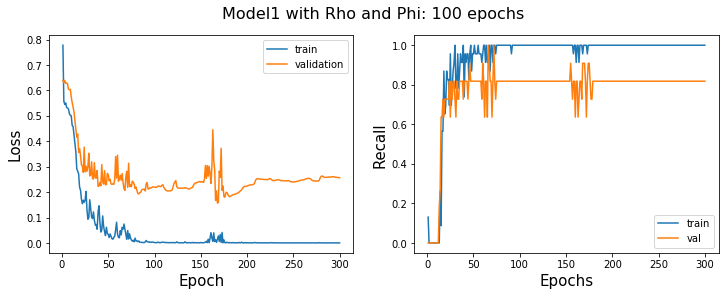

In [507]:
lr_plot(model1_hist,'Model1 with Rho and Phi: 100 epochs','lr_plot_model1_rhophi_300epochs.png')

Apon rsearching how i could imporv my score with this CNN arcitecture I cam across a thesis paper by Xiaoyo Yu on Human activity recovnition that referenced an idea from Jiang and Yin (2015) who converted there 1 demensional time series  data into 2 dementional descrete fourier transformation. I was not able to find this paper for free to see what  they ment buy "2d fourier transformation" so i desided to make my own 2d fourier transformation by take the fast forier transformation and sliding windows of time for each sample to make a spectragram like the one use d in audio data  analysis.  

In [65]:
from scipy import signal

In [352]:
rate = 16 #sample frequency <float>

#freqs, times, Sx = signal.spectrogram(X_train_rhophi[1][:,1].T, fs=1,nperseg=53,window='boxcar',)
freqs, times, Sx = signal.spectrogram(X_train_rhophi[1][:,1], nperseg=20,noverlap=2) 

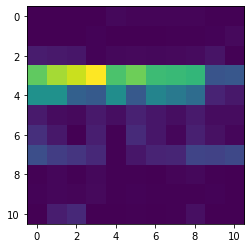

In [353]:
plt.imshow(Sx)

In [508]:
### making an example plot of the spectrograms



the shape i want is (102,11,11,2) for train and (35,11,11,2)

In [366]:
X_train_rhophi.shape

(102, 206, 2)

In [367]:
X_vali_rhophi.shape

(35, 206, 2)

In [370]:
freqs, times, Sxrho = signal.spectrogram(X_train_rhophi[1][:,0], nperseg=20,noverlap=2) 

In [371]:
freqs, times, Sxphi = signal.spectrogram(X_train_rhophi[1][:,1], nperseg=20,noverlap=2) 

In [375]:
np.dstack((Sxrho,Sxphi)).shape #this with 

(11, 11, 2)

In [376]:
def stack_channels(im1, im2):
    return np.dstack((im1,im2))

In [467]:
def ts_df_to_spectrogram(ts_df, channels=2):
    '''input is a 3 demetional data fram of time series data (N,206,2)
    outout is a 4 array of spectrograms (N,11,11,2)'''
    spec_df = np.empty((11,11,channels))
    list_ = []
    for sample in range(ts_df.shape[0]):
        freqs, times, Sx1 = signal.spectrogram(X_train_rhophi[sample][:,0], nperseg=20,noverlap=2) 
        freqs, times, Sx2 = signal.spectrogram(X_train_rhophi[sample][:,1], nperseg=20,noverlap=2)
        im = stack_channels(Sx1,Sx2)
        
        list_.append(im)
        spec_df = np.stack(list_, axis=0)
    return spec_df

In [468]:
X_train_spec = ts_df_to_spectrogram(X_train_rhophi)

In [469]:
X_vali_spec = ts_df_to_spectrogram(X_vali_rhophi)

In [518]:
model2 = Sequential()
model2.add(Conv2D(filters=20, kernel_size=2, activation='relu', input_shape=(11,11,2)))
model2.add(Dropout(0.5))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(filters=20, kernel_size=2, activation='relu'))
model2.add(Dropout(0.5))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Flatten())
model2.add(Dense(50, activation='relu'))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [484]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 9, 9, 64)          1216      
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)               

In [519]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics1)

In [520]:
tensorboard = TensorBoard(log_dir='./logs8', histogram_freq=2, batch_size=32, write_graph=True, write_grads=True, write_images=True)
model2_hist = model2.fit(X_train_spec, y_train_rhophi, batch_size=batch_size, epochs=300, 
          validation_data = (X_vali_spec,y_vali_rhophi), callbacks = [tensorboard])

Epoch 1/300
4/4 [==============================] - 1s 179ms/step - loss: 0.5835 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.6273 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 0.5266 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.6244 - val_accuracy: 0.7143 - val_true_positives: 1.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 10.0000 - val_precision: 1.0000 - val_recall: 0.0909
Epoch 3/300
4/4 [==============================] - 0s 11ms/step - loss: 0.4786 

Epoch 18/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1768 - accuracy: 0.9412 - true_positives: 18.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 5.0000 - precision: 0.9474 - recall: 0.7826 - val_loss: 0.6695 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 19/300
4/4 [==============================] - 0s 13ms/step - loss: 0.2414 - accuracy: 0.9118 - true_positives: 17.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 6.0000 - precision: 0.8500 - recall: 0.7391 - val_loss: 0.6742 - val_accuracy: 0.6571 - val_true_positives: 3.0000 - val_true_negatives: 20.0000 - val_false_positives: 4.0000 - val_false_negatives: 8.0000 - val_precision: 0.4286 - val_recall: 0.2727
Epoch 20/300
4/4 [==============================] - 0s 11ms/step - loss: 0.1516 - accuracy: 0.9412 - true_po

4/4 [==============================] - 0s 7ms/step - loss: 0.2304 - accuracy: 0.9020 - true_positives: 18.0000 - true_negatives: 74.0000 - false_positives: 5.0000 - false_negatives: 5.0000 - precision: 0.7826 - recall: 0.7826 - val_loss: 0.7704 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 37/300
4/4 [==============================] - 0s 11ms/step - loss: 0.1482 - accuracy: 0.9314 - true_positives: 18.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 5.0000 - precision: 0.9000 - recall: 0.7826 - val_loss: 0.7741 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 38/300
4/4 [==============================] - 0s 8ms/step - loss: 0.1281 - accuracy: 0.9412 - true_positives: 21.000

4/4 [==============================] - 0s 8ms/step - loss: 0.1620 - accuracy: 0.9314 - true_positives: 22.0000 - true_negatives: 73.0000 - false_positives: 6.0000 - false_negatives: 1.0000 - precision: 0.7857 - recall: 0.9565 - val_loss: 0.8199 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 55/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1623 - accuracy: 0.9216 - true_positives: 20.0000 - true_negatives: 74.0000 - false_positives: 5.0000 - false_negatives: 3.0000 - precision: 0.8000 - recall: 0.8696 - val_loss: 0.7961 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 56/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0823 - accuracy: 0.9902 - true_positives: 22.000

4/4 [==============================] - 0s 9ms/step - loss: 0.0861 - accuracy: 0.9412 - true_positives: 20.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 3.0000 - precision: 0.8696 - recall: 0.8696 - val_loss: 0.9144 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 73/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0908 - accuracy: 0.9412 - true_positives: 21.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 2.0000 - precision: 0.8400 - recall: 0.9130 - val_loss: 0.9275 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 74/300
4/4 [==============================] - 0s 8ms/step - loss: 0.1269 - accuracy: 0.9510 - true_positives: 19.000

4/4 [==============================] - 0s 7ms/step - loss: 0.0922 - accuracy: 0.9510 - true_positives: 22.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 1.0000 - precision: 0.8462 - recall: 0.9565 - val_loss: 1.1239 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 91/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1308 - accuracy: 0.9510 - true_positives: 19.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 4.0000 - precision: 0.9500 - recall: 0.8261 - val_loss: 1.1213 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 92/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0954 - accuracy: 0.9706 - true_positives: 22.000

4/4 [==============================] - 0s 8ms/step - loss: 0.0353 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 1.2283 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 109/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0275 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 1.2464 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 110/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0648 - accuracy: 0.9706 - true_positiv

4/4 [==============================] - 0s 10ms/step - loss: 0.0648 - accuracy: 0.9706 - true_positives: 20.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 3.0000 - precision: 1.0000 - recall: 0.8696 - val_loss: 1.3485 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 127/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1474 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 1.2813 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 128/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0781 - accuracy: 0.9608 - true_positi

4/4 [==============================] - 0s 10ms/step - loss: 0.0400 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 1.4847 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 145/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0291 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 1.4807 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 146/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0273 - accuracy: 0.9902 - true_positi

4/4 [==============================] - 0s 8ms/step - loss: 0.0631 - accuracy: 0.9706 - true_positives: 22.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 1.0000 - precision: 0.9167 - recall: 0.9565 - val_loss: 1.6193 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 163/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0286 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 1.6728 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 164/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0474 - accuracy: 0.9804 - true_positives: 

4/4 [==============================] - 0s 8ms/step - loss: 0.0273 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 1.7084 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 181/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0393 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 1.6892 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 182/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0400 - accuracy: 0.9804 - true_positiv

4/4 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 1.8046 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 199/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0390 - accuracy: 0.9804 - true_positives: 22.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 1.0000 - precision: 0.9565 - recall: 0.9565 - val_loss: 1.8158 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 200/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9902 - true_positives: 

4/4 [==============================] - 0s 9ms/step - loss: 0.0330 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 2.1156 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 217/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0434 - accuracy: 0.9804 - true_positives: 22.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 1.0000 - precision: 0.9565 - recall: 0.9565 - val_loss: 2.0488 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 218/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 0.9706 - true_positives: 

4/4 [==============================] - 0s 7ms/step - loss: 0.0086 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0337 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 235/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0528 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 236/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0143 - accuracy: 1.0000 - true_

4/4 [==============================] - 0s 8ms/step - loss: 0.0130 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 2.2162 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 253/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2822 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 254/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9706 - true_pos

4/4 [==============================] - 0s 8ms/step - loss: 0.0106 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.1259 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 271/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0257 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 2.1486 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 272/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0198 - accuracy: 0.9902 - true_pos

4/4 [==============================] - 0s 8ms/step - loss: 0.0069 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2392 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 289/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0832 - accuracy: 0.9804 - true_positives: 22.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 1.0000 - precision: 0.9565 - recall: 0.9565 - val_loss: 2.1776 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 290/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.9902 - true_positiv

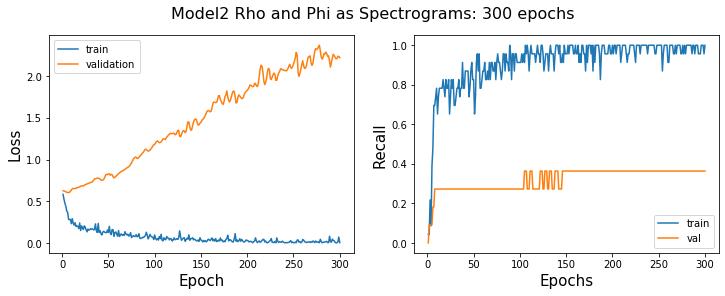

In [521]:
lr_plot(model2_hist,'Model2 Rho and Phi as Spectrograms: 300 epochs','model2_specs_300_3.png')

lets try an make this better

**First I will try and switch my max pooling to havven before drop out.**

In [523]:
model3 = Sequential()
model3.add(Conv2D(filters=20, kernel_size=2, activation='relu', input_shape=(11,11,2)))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.5))
model3.add(Conv2D(filters=20, kernel_size=2, activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.5))
model3.add(Flatten())
model3.add(Dense(50, activation='relu'))
model3.add(Dense(25, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [524]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics1)

In [525]:
tensorboard = TensorBoard(log_dir='./logs9', histogram_freq=2, batch_size=32, write_graph=True, write_grads=True, write_images=True)
model3_hist = model3.fit(X_train_spec, y_train_rhophi, batch_size=batch_size, epochs=300, 
          validation_data = (X_vali_spec,y_vali_rhophi), callbacks = [tensorboard])

Epoch 1/300
4/4 [==============================] - 1s 188ms/step - loss: 0.6670 - accuracy: 0.5196 - true_positives: 14.0000 - true_negatives: 39.0000 - false_positives: 40.0000 - false_negatives: 9.0000 - precision: 0.2593 - recall: 0.6087 - val_loss: 0.6279 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 7ms/step - loss: 0.6234 - accuracy: 0.7157 - true_positives: 7.0000 - true_negatives: 66.0000 - false_positives: 13.0000 - false_negatives: 16.0000 - precision: 0.3500 - recall: 0.3043 - val_loss: 0.5994 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 0s 10ms/step - loss: 0.

Epoch 18/300
4/4 [==============================] - 0s 9ms/step - loss: 0.3407 - accuracy: 0.8824 - true_positives: 12.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 11.0000 - precision: 0.9231 - recall: 0.5217 - val_loss: 0.6997 - val_accuracy: 0.6000 - val_true_positives: 2.0000 - val_true_negatives: 19.0000 - val_false_positives: 5.0000 - val_false_negatives: 9.0000 - val_precision: 0.2857 - val_recall: 0.1818
Epoch 19/300
4/4 [==============================] - 0s 13ms/step - loss: 0.3304 - accuracy: 0.8725 - true_positives: 14.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 9.0000 - precision: 0.7778 - recall: 0.6087 - val_loss: 0.7104 - val_accuracy: 0.6000 - val_true_positives: 2.0000 - val_true_negatives: 19.0000 - val_false_positives: 5.0000 - val_false_negatives: 9.0000 - val_precision: 0.2857 - val_recall: 0.1818
Epoch 20/300
4/4 [==============================] - 0s 9ms/step - loss: 0.3537 - accuracy: 0.8529 - true_pos

4/4 [==============================] - 0s 8ms/step - loss: 0.2478 - accuracy: 0.8824 - true_positives: 13.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 10.0000 - precision: 0.8667 - recall: 0.5652 - val_loss: 0.7105 - val_accuracy: 0.6000 - val_true_positives: 1.0000 - val_true_negatives: 20.0000 - val_false_positives: 4.0000 - val_false_negatives: 10.0000 - val_precision: 0.2000 - val_recall: 0.0909
Epoch 37/300
4/4 [==============================] - 0s 10ms/step - loss: 0.3058 - accuracy: 0.8824 - true_positives: 12.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 11.0000 - precision: 0.9231 - recall: 0.5217 - val_loss: 0.7168 - val_accuracy: 0.6000 - val_true_positives: 1.0000 - val_true_negatives: 20.0000 - val_false_positives: 4.0000 - val_false_negatives: 10.0000 - val_precision: 0.2000 - val_recall: 0.0909
Epoch 38/300
4/4 [==============================] - 0s 7ms/step - loss: 0.2818 - accuracy: 0.8725 - true_positives: 13

4/4 [==============================] - 0s 7ms/step - loss: 0.2502 - accuracy: 0.8824 - true_positives: 16.0000 - true_negatives: 74.0000 - false_positives: 5.0000 - false_negatives: 7.0000 - precision: 0.7619 - recall: 0.6957 - val_loss: 0.7951 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 55/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2382 - accuracy: 0.9510 - true_positives: 19.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 4.0000 - precision: 0.9500 - recall: 0.8261 - val_loss: 0.7970 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 56/300
4/4 [==============================] - 0s 7ms/step - loss: 0.2879 - accuracy: 0.8922 - true_positives: 16.0000

4/4 [==============================] - 0s 9ms/step - loss: 0.2142 - accuracy: 0.9216 - true_positives: 16.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 7.0000 - precision: 0.9412 - recall: 0.6957 - val_loss: 0.8239 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 73/300
4/4 [==============================] - 0s 10ms/step - loss: 0.2250 - accuracy: 0.9216 - true_positives: 15.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 8.0000 - precision: 1.0000 - recall: 0.6522 - val_loss: 0.8360 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 74/300
4/4 [==============================] - 0s 7ms/step - loss: 0.2763 - accuracy: 0.8627 - true_positives: 13

4/4 [==============================] - 0s 8ms/step - loss: 0.2212 - accuracy: 0.9020 - true_positives: 17.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 6.0000 - precision: 0.8095 - recall: 0.7391 - val_loss: 0.9557 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 91/300
4/4 [==============================] - 0s 10ms/step - loss: 0.2323 - accuracy: 0.8922 - true_positives: 18.0000 - true_negatives: 73.0000 - false_positives: 6.0000 - false_negatives: 5.0000 - precision: 0.7500 - recall: 0.7826 - val_loss: 0.9550 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 92/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2599 - accuracy: 0.9020 - true_positives: 16.000

4/4 [==============================] - 0s 9ms/step - loss: 0.1560 - accuracy: 0.9314 - true_positives: 18.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 5.0000 - precision: 0.9000 - recall: 0.7826 - val_loss: 1.0543 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 109/300
4/4 [==============================] - 0s 10ms/step - loss: 0.2460 - accuracy: 0.8824 - true_positives: 16.0000 - true_negatives: 74.0000 - false_positives: 5.0000 - false_negatives: 7.0000 - precision: 0.7619 - recall: 0.6957 - val_loss: 1.0606 - val_accuracy: 0.6571 - val_true_positives: 3.0000 - val_true_negatives: 20.0000 - val_false_positives: 4.0000 - val_false_negatives: 8.0000 - val_precision: 0.4286 - val_recall: 0.2727
Epoch 110/300
4/4 [==============================] - 0s 8ms/step - loss: 0.1473 - accuracy: 0.9412 - true_positives: 20.0

4/4 [==============================] - 0s 7ms/step - loss: 0.1243 - accuracy: 0.9314 - true_positives: 19.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 4.0000 - precision: 0.8636 - recall: 0.8261 - val_loss: 1.0784 - val_accuracy: 0.6571 - val_true_positives: 3.0000 - val_true_negatives: 20.0000 - val_false_positives: 4.0000 - val_false_negatives: 8.0000 - val_precision: 0.4286 - val_recall: 0.2727
Epoch 127/300
4/4 [==============================] - 0s 9ms/step - loss: 0.1539 - accuracy: 0.9314 - true_positives: 18.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 5.0000 - precision: 0.9000 - recall: 0.7826 - val_loss: 1.0899 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 128/300
4/4 [==============================] - 0s 7ms/step - loss: 0.1497 - accuracy: 0.9118 - true_positives: 18.00

4/4 [==============================] - 0s 7ms/step - loss: 0.1840 - accuracy: 0.9510 - true_positives: 18.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 5.0000 - precision: 1.0000 - recall: 0.7826 - val_loss: 1.0998 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 145/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1866 - accuracy: 0.9216 - true_positives: 15.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 8.0000 - precision: 1.0000 - recall: 0.6522 - val_loss: 1.0999 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 146/300
4/4 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9510 - true_positiv

4/4 [==============================] - 0s 8ms/step - loss: 0.1258 - accuracy: 0.9412 - true_positives: 20.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 3.0000 - precision: 0.8696 - recall: 0.8696 - val_loss: 1.2722 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 163/300
4/4 [==============================] - 0s 9ms/step - loss: 0.1457 - accuracy: 0.9314 - true_positives: 18.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 5.0000 - precision: 0.9000 - recall: 0.7826 - val_loss: 1.2882 - val_accuracy: 0.6286 - val_true_positives: 3.0000 - val_true_negatives: 19.0000 - val_false_positives: 5.0000 - val_false_negatives: 8.0000 - val_precision: 0.3750 - val_recall: 0.2727
Epoch 164/300
4/4 [==============================] - 0s 8ms/step - loss: 0.1230 - accuracy: 0.9510 - true_positives: 19.00

4/4 [==============================] - 0s 7ms/step - loss: 0.1112 - accuracy: 0.9510 - true_positives: 19.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 4.0000 - precision: 0.9500 - recall: 0.8261 - val_loss: 1.4067 - val_accuracy: 0.6286 - val_true_positives: 3.0000 - val_true_negatives: 19.0000 - val_false_positives: 5.0000 - val_false_negatives: 8.0000 - val_precision: 0.3750 - val_recall: 0.2727
Epoch 181/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1164 - accuracy: 0.9608 - true_positives: 19.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 4.0000 - precision: 1.0000 - recall: 0.8261 - val_loss: 1.3956 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 182/300
4/4 [==============================] - 0s 7ms/step - loss: 0.1018 - accuracy: 0.9608 - true_positives: 

4/4 [==============================] - 0s 9ms/step - loss: 0.1467 - accuracy: 0.9608 - true_positives: 20.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 3.0000 - precision: 0.9524 - recall: 0.8696 - val_loss: 1.4871 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 199/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0927 - accuracy: 0.9608 - true_positives: 19.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 4.0000 - precision: 1.0000 - recall: 0.8261 - val_loss: 1.4940 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 200/300
4/4 [==============================] - 0s 8ms/step - loss: 0.1233 - accuracy: 0.9314 - true_positives: 

4/4 [==============================] - 0s 7ms/step - loss: 0.1106 - accuracy: 0.9706 - true_positives: 21.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 2.0000 - precision: 0.9545 - recall: 0.9130 - val_loss: 1.6615 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 217/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1516 - accuracy: 0.9412 - true_positives: 21.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 2.0000 - precision: 0.8400 - recall: 0.9130 - val_loss: 1.6627 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 218/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0835 - accuracy: 0.9706 - true_positives: 22.0

4/4 [==============================] - 0s 8ms/step - loss: 0.1314 - accuracy: 0.9314 - true_positives: 21.0000 - true_negatives: 74.0000 - false_positives: 5.0000 - false_negatives: 2.0000 - precision: 0.8077 - recall: 0.9130 - val_loss: 1.8057 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 235/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1105 - accuracy: 0.9314 - true_positives: 19.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 4.0000 - precision: 0.8636 - recall: 0.8261 - val_loss: 1.8114 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 236/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0818 - accuracy: 0.9706 - true_positives: 20.0

4/4 [==============================] - 0s 8ms/step - loss: 0.0656 - accuracy: 0.9706 - true_positives: 21.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 2.0000 - precision: 0.9545 - recall: 0.9130 - val_loss: 1.8433 - val_accuracy: 0.5429 - val_true_positives: 3.0000 - val_true_negatives: 16.0000 - val_false_positives: 8.0000 - val_false_negatives: 8.0000 - val_precision: 0.2727 - val_recall: 0.2727
Epoch 253/300
4/4 [==============================] - 0s 9ms/step - loss: 0.1099 - accuracy: 0.9706 - true_positives: 21.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 2.0000 - precision: 0.9545 - recall: 0.9130 - val_loss: 1.8529 - val_accuracy: 0.5429 - val_true_positives: 3.0000 - val_true_negatives: 16.0000 - val_false_positives: 8.0000 - val_false_negatives: 8.0000 - val_precision: 0.2727 - val_recall: 0.2727
Epoch 254/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0948 - accuracy: 0.9706 - true_positives: 22.00

4/4 [==============================] - 0s 7ms/step - loss: 0.0566 - accuracy: 0.9804 - true_positives: 22.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 1.0000 - precision: 0.9565 - recall: 0.9565 - val_loss: 1.9255 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 271/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0485 - accuracy: 0.9804 - true_positives: 22.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 1.0000 - precision: 0.9565 - recall: 0.9565 - val_loss: 1.9407 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 272/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0918 - accuracy: 0.9510 - true_positives: 21.00

4/4 [==============================] - 0s 8ms/step - loss: 0.0599 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 2.2343 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 289/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0537 - accuracy: 0.9804 - true_positives: 22.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 1.0000 - precision: 0.9565 - recall: 0.9565 - val_loss: 2.2550 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 290/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0790 - accuracy: 0.9706 - true_positives: 2

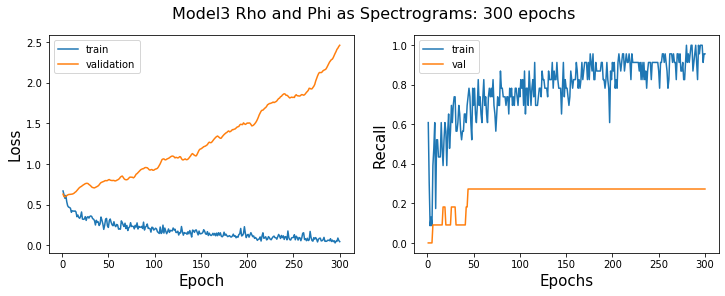

In [526]:
lr_plot(model3_hist,'Model3 Rho and Phi as Spectrograms: 300 epochs','model2_specs_300_switch3.png')

**that seemed to make it worse so i am going to switch those back around.**

In [527]:
model4 = Sequential()
model4.add(Conv2D(filters=20, kernel_size=(3,3), activation='relu', input_shape=(11,11,2)))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.5))
model4.add(Conv2D(filters=20, kernel_size=(3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.5))
model4.add(Flatten())
model4.add(Dense(50, activation='relu'))
model4.add(Dense(25, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

In [528]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics1)

In [529]:
tensorboard = TensorBoard(log_dir='./logs10', histogram_freq=2, batch_size=32, write_graph=True, write_grads=True, write_images=True)
model4_hist = model4.fit(X_train_spec, y_train_rhophi, batch_size=batch_size, epochs=300, 
          validation_data = (X_vali_spec,y_vali_rhophi), callbacks = [tensorboard])

Epoch 1/300
4/4 [==============================] - 1s 190ms/step - loss: 0.6043 - accuracy: 0.7353 - true_positives: 4.0000 - true_negatives: 71.0000 - false_positives: 8.0000 - false_negatives: 19.0000 - precision: 0.3333 - recall: 0.1739 - val_loss: 0.6342 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 0.5878 - accuracy: 0.7647 - true_positives: 1.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 22.0000 - precision: 0.3333 - recall: 0.0435 - val_loss: 0.6126 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 0s 13ms/step - loss: 0.5

4/4 [==============================] - 0s 10ms/step - loss: 0.3426 - accuracy: 0.8627 - true_positives: 13.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 10.0000 - precision: 0.7647 - recall: 0.5652 - val_loss: 0.6368 - val_accuracy: 0.6571 - val_true_positives: 3.0000 - val_true_negatives: 20.0000 - val_false_positives: 4.0000 - val_false_negatives: 8.0000 - val_precision: 0.4286 - val_recall: 0.2727
Epoch 18/300
4/4 [==============================] - 0s 10ms/step - loss: 0.3406 - accuracy: 0.8824 - true_positives: 13.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 10.0000 - precision: 0.8667 - recall: 0.5652 - val_loss: 0.6485 - val_accuracy: 0.6571 - val_true_positives: 3.0000 - val_true_negatives: 20.0000 - val_false_positives: 4.0000 - val_false_negatives: 8.0000 - val_precision: 0.4286 - val_recall: 0.2727
Epoch 19/300
4/4 [==============================] - 0s 13ms/step - loss: 0.3051 - accuracy: 0.8725 - true_positives: 13

4/4 [==============================] - 0s 9ms/step - loss: 0.2742 - accuracy: 0.8725 - true_positives: 14.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 9.0000 - precision: 0.7778 - recall: 0.6087 - val_loss: 0.8839 - val_accuracy: 0.6571 - val_true_positives: 4.0000 - val_true_negatives: 19.0000 - val_false_positives: 5.0000 - val_false_negatives: 7.0000 - val_precision: 0.4444 - val_recall: 0.3636
Epoch 36/300
4/4 [==============================] - 0s 9ms/step - loss: 0.2518 - accuracy: 0.8922 - true_positives: 14.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 9.0000 - precision: 0.8750 - recall: 0.6087 - val_loss: 0.8930 - val_accuracy: 0.6571 - val_true_positives: 4.0000 - val_true_negatives: 19.0000 - val_false_positives: 5.0000 - val_false_negatives: 7.0000 - val_precision: 0.4444 - val_recall: 0.3636
Epoch 37/300
4/4 [==============================] - 0s 10ms/step - loss: 0.2399 - accuracy: 0.9020 - true_positives: 15.000

4/4 [==============================] - 0s 10ms/step - loss: 0.2356 - accuracy: 0.8922 - true_positives: 17.0000 - true_negatives: 74.0000 - false_positives: 5.0000 - false_negatives: 6.0000 - precision: 0.7727 - recall: 0.7391 - val_loss: 0.9949 - val_accuracy: 0.6571 - val_true_positives: 4.0000 - val_true_negatives: 19.0000 - val_false_positives: 5.0000 - val_false_negatives: 7.0000 - val_precision: 0.4444 - val_recall: 0.3636
Epoch 54/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2120 - accuracy: 0.8824 - true_positives: 15.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 8.0000 - precision: 0.7895 - recall: 0.6522 - val_loss: 1.0010 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 55/300
4/4 [==============================] - 0s 11ms/step - loss: 0.2027 - accuracy: 0.8725 - true_positives: 15.00

4/4 [==============================] - 0s 9ms/step - loss: 0.1940 - accuracy: 0.9216 - true_positives: 18.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 5.0000 - precision: 0.8571 - recall: 0.7826 - val_loss: 1.1423 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 72/300
4/4 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.9510 - true_positives: 18.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 5.0000 - precision: 1.0000 - recall: 0.7826 - val_loss: 1.1428 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 73/300
4/4 [==============================] - 0s 11ms/step - loss: 0.2200 - accuracy: 0.8725 - true_positives: 15

4/4 [==============================] - 0s 10ms/step - loss: 0.1433 - accuracy: 0.9412 - true_positives: 20.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 3.0000 - precision: 0.8696 - recall: 0.8696 - val_loss: 1.3315 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 90/300
4/4 [==============================] - 0s 9ms/step - loss: 0.1288 - accuracy: 0.9510 - true_positives: 20.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 3.0000 - precision: 0.9091 - recall: 0.8696 - val_loss: 1.3323 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 91/300
4/4 [==============================] - 0s 9ms/step - loss: 0.1675 - accuracy: 0.9020 - true_positives: 17.000

4/4 [==============================] - 0s 12ms/step - loss: 0.1135 - accuracy: 0.9314 - true_positives: 22.0000 - true_negatives: 73.0000 - false_positives: 6.0000 - false_negatives: 1.0000 - precision: 0.7857 - recall: 0.9565 - val_loss: 1.5227 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 108/300
4/4 [==============================] - 0s 9ms/step - loss: 0.1036 - accuracy: 0.9510 - true_positives: 21.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 2.0000 - precision: 0.8750 - recall: 0.9130 - val_loss: 1.5518 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 109/300
4/4 [==============================] - 0s 11ms/step - loss: 0.1183 - accuracy: 0.9412 - true_positives: 20.

4/4 [==============================] - 0s 11ms/step - loss: 0.0967 - accuracy: 0.9510 - true_positives: 20.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 3.0000 - precision: 0.9091 - recall: 0.8696 - val_loss: 1.6839 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 126/300
4/4 [==============================] - 0s 8ms/step - loss: 0.1096 - accuracy: 0.9510 - true_positives: 19.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 4.0000 - precision: 0.9500 - recall: 0.8261 - val_loss: 1.7086 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 127/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0997 - accuracy: 0.9706 - true_positives: 21.

4/4 [==============================] - 0s 11ms/step - loss: 0.0994 - accuracy: 0.9510 - true_positives: 19.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 4.0000 - precision: 0.9500 - recall: 0.8261 - val_loss: 1.9606 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 144/300
4/4 [==============================] - 0s 9ms/step - loss: 0.1169 - accuracy: 0.9608 - true_positives: 21.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 2.0000 - precision: 0.9130 - recall: 0.9130 - val_loss: 1.9723 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 145/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0683 - accuracy: 0.9608 - true_positives: 21.

4/4 [==============================] - 0s 13ms/step - loss: 0.0913 - accuracy: 0.9706 - true_positives: 22.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 1.0000 - precision: 0.9167 - recall: 0.9565 - val_loss: 2.2050 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 162/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0818 - accuracy: 0.9510 - true_positives: 20.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 3.0000 - precision: 0.9091 - recall: 0.8696 - val_loss: 2.2048 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 163/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0877 - accuracy: 0.9608 - true_positives: 22

4/4 [==============================] - 0s 12ms/step - loss: 0.0697 - accuracy: 0.9706 - true_positives: 23.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00 - precision: 0.8846 - recall: 1.0000 - val_loss: 2.3403 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 180/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0893 - accuracy: 0.9510 - true_positives: 21.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 2.0000 - precision: 0.8750 - recall: 0.9130 - val_loss: 2.3981 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 181/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0613 - accuracy: 0.9804 - true_positives:

4/4 [==============================] - 0s 11ms/step - loss: 0.0994 - accuracy: 0.9608 - true_positives: 20.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 3.0000 - precision: 0.9524 - recall: 0.8696 - val_loss: 2.6385 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 198/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0522 - accuracy: 0.9804 - true_positives: 23.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00 - precision: 0.9200 - recall: 1.0000 - val_loss: 2.5761 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 199/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1115 - accuracy: 0.9510 - true_positives:

4/4 [==============================] - 0s 11ms/step - loss: 0.0526 - accuracy: 0.9706 - true_positives: 23.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00 - precision: 0.8846 - recall: 1.0000 - val_loss: 2.7609 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 216/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0401 - accuracy: 0.9804 - true_positives: 23.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00 - precision: 0.9200 - recall: 1.0000 - val_loss: 2.8199 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 217/300
4/4 [==============================] - 0s 9ms/step - loss: 0.1045 - accuracy: 0.9706 - true_positiv

4/4 [==============================] - 0s 11ms/step - loss: 0.0592 - accuracy: 0.9804 - true_positives: 23.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00 - precision: 0.9200 - recall: 1.0000 - val_loss: 2.7663 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 234/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0920 - accuracy: 0.9804 - true_positives: 23.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00 - precision: 0.9200 - recall: 1.0000 - val_loss: 2.7757 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 235/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0306 - accuracy: 0.9902 - true_positi

4/4 [==============================] - 0s 11ms/step - loss: 0.0311 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.6196 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 252/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0478 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 2.6416 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 253/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0858 - accuracy: 0.9706 - true_p

4/4 [==============================] - 0s 11ms/step - loss: 0.0328 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 3.1837 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 270/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0289 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 3.1661 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 271/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0231 - accuracy: 1.0000 - true_posit

4/4 [==============================] - 0s 11ms/step - loss: 0.0210 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.3314 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 288/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0989 - accuracy: 0.9706 - true_positives: 22.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 1.0000 - precision: 0.9167 - recall: 0.9565 - val_loss: 3.3277 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 289/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0436 - accuracy: 0.9902 - true_posit

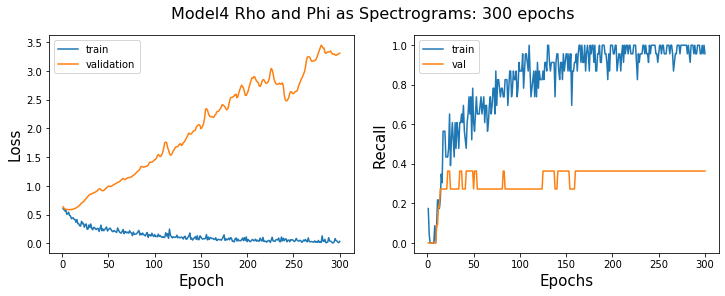

In [530]:
lr_plot(model4_hist,'Model4 Rho and Phi as Spectrograms: 300 epochs','model4_specs_300.png')